# Imports

In [44]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot
import numpy
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate

# Load data

In [54]:
x_dict = {}
values = ['0.01','0.02', '0.03', '0.04', '0.05', '0.06', '0.07', '0.08', '0.09', '0.1', '0.11', '0.12', '0.13',
          '0.14', '0.16', '0.18', '0.2', '0.22', '0.24', '0.26', '0.28']

for value in values:
    split_x = {}
    split_x['test'] = pd.read_table(f'/media/storage/TG/data/chip/superpop_split/pca_pruning2/pca_pruning{value}/ALL/fold_0_test_projections.csv.eigenvec.sscore')
    split_x['train'] = pd.read_table(f'/media/storage/TG/data/chip/superpop_split/pca_pruning2/pca_pruning{value}/ALL/fold_0_train_projections.csv.eigenvec.sscore')
    split_x['val'] = pd.read_table(f'/media/storage/TG/data/chip/superpop_split/pca_pruning2/pca_pruning{value}/ALL/fold_0_val_projections.csv.eigenvec.sscore')

    split_x['test.fake'] = pd.read_table(f'/media/storage/TG/data/chip/superpop_split/pca_pruning2/pca_pruning{value}/ALL.fake/fold_0_test_projections.csv.eigenvec.sscore')
    split_x['train.fake'] = pd.read_table(f'/media/storage/TG/data/chip/superpop_split/pca_pruning2/pca_pruning{value}/ALL.fake/fold_0_train_projections.csv.eigenvec.sscore')
    split_x['val.fake'] = pd.read_table(f'/media/storage/TG/data/chip/superpop_split/pca_pruning2/pca_pruning{value}/ALL.fake/fold_0_val_projections.csv.eigenvec.sscore')

    x_dict[value] = split_x


test_y = pd.read_table('/media/storage/TG/data_compare/new_data/y/fold_0_test.tsv')
train_y = pd.read_table('/media/storage/TG/data_compare/new_data/y/fold_0_train.tsv')
val_y = pd.read_table('/media/storage/TG/data_compare/new_data/y/fold_0_val.tsv')


# Process data

In [55]:
# Loading into pandas
y = pd.concat([val_y, test_y, train_y]).rename_axis('index').reset_index()
for value in values:
    x_dict[value+'prune'] = pd.concat([x_dict[value]['val'], x_dict[value]['test'], x_dict[value]['train']]).rename(columns={'#IID': 'IID'}).set_index('IID').filter(regex='^PC*').reindex(y.set_index('IID').index)
    x_dict[value+'.fake'] = pd.concat([x_dict[value]['val.fake'], x_dict[value]['test.fake'], x_dict[value]['train.fake']]).rename(columns={'#IID': 'IID'}).set_index('IID').filter(regex='^PC*').reindex(y.set_index('IID').index)
    x_dict[value+'_np'] = x_dict[value + 'prune'].values
    x_dict[value+'.fake'+'_np'] = x_dict[value+'.fake'].values

# Converting into numpy
_, y_np = numpy.unique(y.iloc[:, -1].values.astype(numpy.ndarray), return_inverse=True)

# Model and training

In [56]:
model = RandomForestClassifier(min_samples_leaf=1,
                               n_estimators=100)

In [57]:
scores_total = {}
for value in values:
    value_score = {}
    scores = cross_validate(model, x_dict[value + '_np'], y_np, cv=5, return_train_score=True)
    value_score['train'] = sum(scores["train_score"]) / len(scores["train_score"])
    value_score['test'] = sum(scores["test_score"]) / len(scores["test_score"])
    print(f"Pruning\n"
          f"VALUE: {value}\n"
          f"Train accuracies: {value_score['train']}\n"
      f"Test accuracies: {value_score['test']}")

    scores = cross_validate(model, x_dict[value +'.fake'+ '_np'], y_np, cv=5, return_train_score=True)
    value_score['train.fake'] = sum(scores["train_score"]) / len(scores["train_score"])
    value_score['test.fake'] = sum(scores["test_score"]) / len(scores["test_score"])
    scores_total[value] = value_score
    print(f"FAKE\n"
          f"VALUE: {value}\n"
          f"Train accuracies: {value_score['train.fake']}\n"
      f"Test accuracies: {value_score['test.fake']}")

Pruning
VALUE: 0.01
Train accuracies: 1.0
Test accuracies: 0.7656277717193748
FAKE
VALUE: 0.01
Train accuracies: 1.0
Test accuracies: 0.7233260632497275
Pruning
VALUE: 0.02
Train accuracies: 1.0
Test accuracies: 0.831173391494002
FAKE
VALUE: 0.02
Train accuracies: 1.0
Test accuracies: 0.7900225372591784
Pruning
VALUE: 0.03
Train accuracies: 1.0
Test accuracies: 0.8616619411123227
FAKE
VALUE: 0.03
Train accuracies: 1.0
Test accuracies: 0.8174569247546348
Pruning
VALUE: 0.04
Train accuracies: 1.0
Test accuracies: 0.8711901126862959
FAKE
VALUE: 0.04
Train accuracies: 1.0
Test accuracies: 0.842990185387132
Pruning
VALUE: 0.05
Train accuracies: 1.0
Test accuracies: 0.8875826972010177
FAKE
VALUE: 0.05
Train accuracies: 1.0
Test accuracies: 0.8574714649218466
Pruning
VALUE: 0.06
Train accuracies: 1.0
Test accuracies: 0.8929160305343512
FAKE
VALUE: 0.06
Train accuracies: 1.0
Test accuracies: 0.8696670301708469
Pruning
VALUE: 0.07
Train accuracies: 1.0
Test accuracies: 0.9001541257724464
FAKE
V

# Results

[Text(0.5, 0, 'pruning threshold'), Text(0, 0.5, 'RF accuracy')]

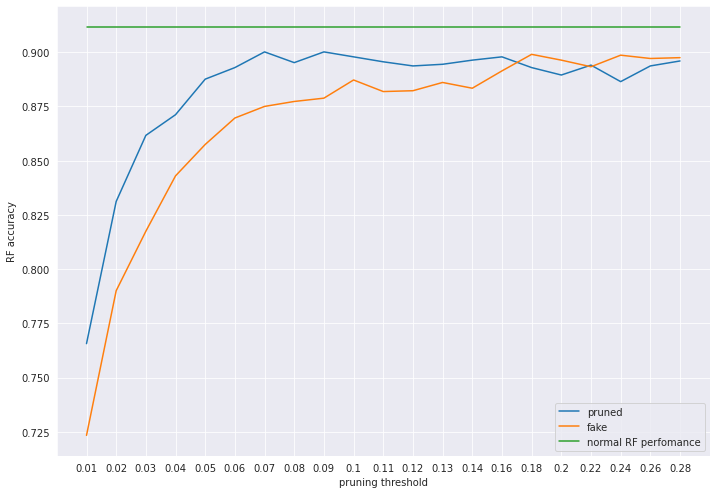

In [58]:
keys = values
baseline = [0.91178]*len(keys)
a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
vals_true = [scores_total[k]['test'] for k in keys]
vals_fake = [scores_total[k]['test.fake'] for k in keys]
plot = sns.lineplot(x=keys, y=vals_true, label="pruned", ax=ax)
plot = sns.lineplot(x=keys, y=vals_fake, label="fake", ax=ax)
plot = sns.lineplot(x=keys, y=baseline, label="normal RF perfomance", ax=ax)
plot.set(xlabel='pruning threshold', ylabel='RF accuracy')
